# Interior points near harvest edge
This script uses all the ARU locations deployed in Alberta, and applies filters to identify forests in which we can evaluate the edge avoidance of interior forest birds.

All geographical files, layers, and rasters are reprojected in EPSG: 2400 (NAD83 10-TM)

**Filters**
1. Exclude points that are in harvest polygons (form the ABMI harvest regeneration gdb)
2. Identify locations in the Boreal and Foothills ecoregions
3. Identify the nearest harvest polygon for each site
4. Keep sites where the nearest harvest was logged between 1980 and 2023
5. Keep locations that have recordings
6. Filter out locations not within breeding bird season or during dawn chant
7. Exclude points that have more than 1 harvest edge within 500m
8. Get the proportion of tree species within 150m radius for each point

In [2]:
import os
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fiona
import geopandas as gpd
from shapely.geometry import shape
from shapely.ops import nearest_points
import numpy as np
import rasterio
from rasterstats import zonal_stats
from rasterio.features import shapes
from shapely.geometry import shape

# processed_path = "C:/Users/ilebe/Documents/!Masters!/Chapter 3/Data synthesis/0. Data/Processed"
processed_path = r"C:\Users\ilebe\Documents\!Masters!\Forest interior community\Forest-interior-community\0. Data\Processed"
raw_path = "C:/Users/ilebe/Documents/!Masters!/Forest interior community/Forest-interior-community//0. Data/Raw"
output_path = r"C:\Users\ilebe\Documents\!Masters!\Forest interior community\Forest-interior-community\2. Output"
lead_tree_raster_path = r"C:\Users\ilebe\Documents\!Masters!\Alberta-GIS-Ecology-Tools-1\Lead Tree Species\CA_forest_lead_tree_species.tif"
harvest_shp_path = r"C:\Users\ilebe\Documents\!Masters!\Alberta-GIS-Ecology-Tools-1\ABMI-Harvest Regeneration geodatabase\Regen gdb\ABMI_HarvestArea_SpectralRegeneration_2019_v1.shp"

In [2]:
Harvest_polygons_gdf = gpd.read_file(harvest_shp_path)

### A.1 Extract Harvest polygons from the Harvest Regeneration shapefile

In [3]:
Harvest_AREAS_polygons_gdf = Harvest_polygons_gdf[Harvest_polygons_gdf['FEATURE_TY'] == 'HARVEST-AREA']

In [5]:
# Load the CSV
BU_all_points = pd.read_csv(os.path.join(raw_path, 'BU_locations_20240212.csv'))

# Convert the DataFrame to a GeoDataFrame
# longitude values are considered the x-coordinate, while latitude values are the y-coordinate.
BU_points_geo = gpd.GeoDataFrame(BU_all_points, geometry=gpd.points_from_xy(BU_all_points.longitude, BU_all_points.latitude), crs="EPSG:4326")

In [12]:
BU_points_geo.geometry.isna()

0        False
1        False
2        False
3        False
4        False
         ...  
20995    False
20996    False
20997    False
20998    False
20999    False
Name: geometry, Length: 21000, dtype: bool

In [13]:
mask = BU_points_geo['latitude'].isna()
BU_points_geo_COORDS = BU_points_geo[~mask]

,location,latitude,longitude,elevationMeters,bufferRadiusMeters,isHidden,trueCoordinates,comments,internal_wildtrax_id,internal_update_ts,geometry
0,BH3,52.52369,-116.37471,NaN,NaN,Visible,t,NaN,479111,2023-07-11 22:56:23,POINT (-116.37471 52.52369)
1,BH5,52.52123,-116.19895,NaN,NaN,Visible,t,NaN,479157,2023-07-14 15:38:18,POINT (-116.19895 52.52123)
2,BH6,52.50120,-116.14980,NaN,NaN,Visible,t,NaN,479158,2023-07-14 15:41:29,POINT (-116.14980 52.50120)
3,BH7,52.49458,-116.01662,NaN,NaN,Visible,t,NaN,479154,2023-07-14 15:33:14,POINT (-116.01662 52.49458)
4,BH8,52.51334,-115.94275,NaN,NaN,Visible,t,NaN,479153,2023-07-14 15:32:57,POINT (-115.94275 52.51334)
...,...,...,...,...,...,...,...,...,...,...,...
20972,OG-ABMI-926-41-SE,54.13707,-110.75700,NaN,NaN,Visible,t,NaN,54507,2021-03-24 09:39:18,POINT (-110.75700 54.13707)
20973,OG-ABMI-926-41-NE,54.13707,-110.75700,NaN,NaN,Visible,t,NaN,54505,2021-03-24 09:39:18,POINT (-110.75700 54.13707)
20974,OG-ABMI-926-41-SW,54.13707,-110.75700,NaN,NaN,Visible,t,NaN,54509,2021-03-24 09:39:18,POINT (-110.75700 54.13707)
20975,RP:84-07-W4-TRANS:4,56.30909,-110.98417,NaN,NaN,Visible,t,NaN,96236,2021-10-08 01:09:27,POINT (-110.98417 56.30909)


### A.2 Reproject points to NAD 10Tm

In [14]:
BU_points_geo_3400 = BU_points_geo_COORDS.to_crs(epsg=3400)

In [18]:
BU_points_geo_3400.to_file(os.path.join(processed_path, "BU_locations_3400.shp"))

C:\Users\ilebe\AppData\Local\Temp\ipykernel_30048\571243765.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  BU_points_geo_3400.to_file(os.path.join(processed_path, "BU_locations_3400.shp"))


In [16]:
BU_points_geo_3400.crs

<Projected CRS: EPSG:3400>
Name: NAD83 / Alberta 10-TM (Forest)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - Alberta.
- bounds: (-120.0, 48.99, -109.98, 60.0)
Coordinate Operation:
- name: Alberta 10-degree TM (Forest)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
Harvest_AREAS_polygons_gdf.crs

<Projected CRS: EPSG:3400>
Name: NAD83 / Alberta 10-TM (Forest)
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### A.3 Identify points not in harvests

In [19]:
# Perform a spatial join
joined_gdf = gpd.sjoin(BU_points_geo_3400, Harvest_AREAS_polygons_gdf, how="left", predicate='intersects')

# Filter out points not within any polygon
# Points not within polygons will have 'index_right' as NaN after the join
BU_points_not_within_polygons = joined_gdf[joined_gdf.index_right.isna()]

In [48]:
joined_gdf[joined_gdf['location'] == 'WCTHIN:S4:4'].index_right

16469    68682.0
Name: index_right, dtype: float64

In [53]:
joined_gdf[joined_gdf.index_right.isna()][['location', 'index_right']]
joined_gdf[joined_gdf.index_right.isna()]['index_right'].value_counts()
joined_gdf[joined_gdf.index_right.isna()]['index_right']

0       NaN
2       NaN
3       NaN
4       NaN
5       NaN
         ..
20972   NaN
20973   NaN
20974   NaN
20975   NaN
20976   NaN
Name: index_right, Length: 17303, dtype: float64

In [23]:
BU_points_not_within_polygons.head()
BU_points_not_within_polygons.shape

(17303, 56)

In [31]:
BU_points_not_within_polygons.to_file(os.path.join(processed_path, "BU_locations_not_in_harvests_3400.shp"))

C:\Users\ilebe\AppData\Local\Temp\ipykernel_30048\2459931805.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  BU_points_not_within_polygons.to_file(os.path.join(processed_path, "BU_locations_not_in_harvests_3400.shp"))


In [25]:
BU_points_not_within_polygons.columns

Index(['location', 'latitude', 'longitude', 'elevationMeters',
       'bufferRadiusMeters', 'isHidden', 'trueCoordinates', 'comments',
       'internal_wildtrax_id', 'internal_update_ts', 'geometry', 'index_right',
       'OBJECTID', 'SOURCE', 'HFI_ID', 'FEATURE_TY', 'YEAR', 'SECTOR_HFI',
       'Modifier_Y', 'Shape_Leng', 'Shape_Area', 'AnlysID', 'preNBR_m',
       'preNBR_s', 'nbrDstb_m', 'nbrDstb_s', 'hrvYr_m', 'hrvYr_s', 'lnDstb_m',
       'lnDstb_s', 'regStYr_m', 'regStYr_s', 'reg5yr_m', 'reg5yr_s',
       'y2reg80_m', 'y2reg80_s', 'reg2019_m', 'reg2019_s', 'totPolyPix',
       'perRelvPix', 'perNoHrv', 'perMltDstb', 'perOutRng', 'perNoRegn',
       'confSz', 'confRelvPx', 'confCntgPx', 'confHrvYr', 'confLnDstb',
       'confNBRchg', 'confRegn', 'confY2R80', 'conf5yReg', 'confTotSum',
       'regnMetsYN', 'regnAnlyYN'],
      dtype='object')

# B. Target ARU locations near harvests.

There are 17303 locations not within any harvests.<br>
Next, let's look for locations in the boreal forest, with ARU data, which were sampled during the breeding bird survey, in upland spruce/deciduous/mixedwood.

In [51]:
ecoregions = gpd.read_file(r"Z:\BayneLabWorkSpace\ILT_workspace\GIS\Natural_Regions_Subregions_of_Alberta\Natural_Regions_Subregions_of_Alberta.shp")

In [52]:
ecoregions.crs

<Projected CRS: EPSG:3400>
Name: NAD83 / Alberta 10-TM (Forest)
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [55]:
ecoregions_boreal_foot = ecoregions[(ecoregions['NRNAME'] == 'Boreal') | (ecoregions['NRNAME'] == 'Foothills')]
ecoregions_boreal_foot.head()

,OBJECTID,NSRNAME,NSRCODE,NRNAME,Shape_STAr,Shape_STLe,geometry
241,275,Athabasca Plain,AP,Boreal,1.352525e+10,1.145520e+06,"POLYGON ((784426.707 6577413.161, 784486.963 6..."
242,276,Boreal Subarctic,BSR,Boreal,1.178596e+08,5.413865e+04,"POLYGON ((239295.055 6605786.338, 239530.084 6..."
243,277,Boreal Subarctic,BSR,Boreal,2.014016e+08,9.886727e+04,"POLYGON ((285374.191 6610642.913, 285463.233 6..."
244,278,Boreal Subarctic,BSR,Boreal,9.525305e+09,7.227342e+05,"POLYGON ((489495.040 6613706.354, 489971.902 6..."
245,279,Boreal Subarctic,BSR,Boreal,1.978157e+09,2.280782e+05,"POLYGON ((372128.615 6650123.074, 371872.088 6..."


In [61]:
BU_points_not_within_polygons.columns

Index(['location', 'latitude', 'longitude', 'elevationMeters',
       'bufferRadiusMeters', 'isHidden', 'trueCoordinates', 'comments',
       'internal_wildtrax_id', 'internal_update_ts', 'geometry', 'OBJECTID',
       'SOURCE', 'HFI_ID', 'FEATURE_TY', 'YEAR', 'SECTOR_HFI', 'Modifier_Y',
       'Shape_Leng', 'Shape_Area', 'AnlysID', 'preNBR_m', 'preNBR_s',
       'nbrDstb_m', 'nbrDstb_s', 'hrvYr_m', 'hrvYr_s', 'lnDstb_m', 'lnDstb_s',
       'regStYr_m', 'regStYr_s', 'reg5yr_m', 'reg5yr_s', 'y2reg80_m',
       'y2reg80_s', 'reg2019_m', 'reg2019_s', 'totPolyPix', 'perRelvPix',
       'perNoHrv', 'perMltDstb', 'perOutRng', 'perNoRegn', 'confSz',
       'confRelvPx', 'confCntgPx', 'confHrvYr', 'confLnDstb', 'confNBRchg',
       'confRegn', 'confY2R80', 'conf5yReg', 'confTotSum', 'regnMetsYN',
       'regnAnlyYN'],
      dtype='object')

In [57]:
BU_points_not_within_polygons.drop(labels="index_right", axis = 1, inplace=True)
BU_ecoregion_joined = gpd.sjoin(BU_points_not_within_polygons, ecoregions_boreal_foot, how="left", predicate='intersects')

# Filter out points not within any polygon
# Points not within polygons will have 'index_right' as NaN after the join
BU_points_out_harvest_boreal_foothills = BU_ecoregion_joined[BU_ecoregion_joined.index_right.notnull()]

C:\Users\ilebe\AppData\Local\Temp\ipykernel_30048\2204457680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BU_points_not_within_polygons.drop(labels="index_right", axis = 1, inplace=True)


In [58]:
BU_points_out_harvest_boreal_foothills.head()

,location,latitude,longitude,elevationMeters,bufferRadiusMeters,isHidden,trueCoordinates,comments,internal_wildtrax_id,internal_update_ts,...,confTotSum,regnMetsYN,regnAnlyYN,index_right,OBJECTID_right,NSRNAME,NSRCODE,NRNAME,Shape_STAr,Shape_STLe
0,BH3,52.52369,-116.37471,NaN,NaN,Visible,t,NaN,479111,2023-07-11 22:56:23,...,NaN,NaN,NaN,368.0,411.0,Upper Foothills,UF,Foothills,5.471505e+09,1.911567e+06
2,BH6,52.50120,-116.14980,NaN,NaN,Visible,t,NaN,479158,2023-07-14 15:41:29,...,NaN,NaN,NaN,368.0,411.0,Upper Foothills,UF,Foothills,5.471505e+09,1.911567e+06
3,BH7,52.49458,-116.01662,NaN,NaN,Visible,t,NaN,479154,2023-07-14 15:33:14,...,NaN,NaN,NaN,368.0,411.0,Upper Foothills,UF,Foothills,5.471505e+09,1.911567e+06
4,BH8,52.51334,-115.94275,NaN,NaN,Visible,t,NaN,479153,2023-07-14 15:32:57,...,NaN,NaN,NaN,368.0,411.0,Upper Foothills,UF,Foothills,5.471505e+09,1.911567e+06
5,BH9,52.49078,-115.83571,NaN,NaN,Visible,t,NaN,479156,2023-07-14 15:37:29,...,NaN,NaN,NaN,368.0,411.0,Upper Foothills,UF,Foothills,5.471505e+09,1.911567e+06


<AxesSubplot:>

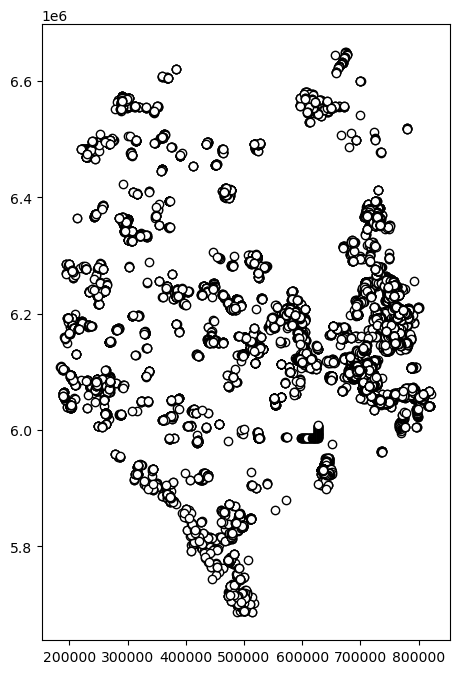

In [59]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

BU_points_out_harvest_boreal_foothills.plot(ax=ax, facecolor = 'white', edgecolor = 'black')

Get the nearest harvest polygon

In [60]:
BU_points_out_harvest_boreal_foothills.to_file(os.path.join(processed_path, "BU_locations_not_in_harv_boreal_foot_3400.shp"))

C:\Users\ilebe\AppData\Local\Temp\ipykernel_30048\2453187274.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  BU_points_out_harvest_boreal_foothills.to_file(os.path.join(processed_path, "BU_locations_not_in_harv_boreal_foot_3400.shp"))


In [71]:
BU_points_out_harvest_boreal_foothills.columns
BU_points_out_harvest_boreal_foothills_trim = BU_points_out_harvest_boreal_foothills[['location', 'latitude', 'longitude','geometry', 'NSRNAME', 'NSRCODE', 'NRNAME']]

# C. Get the nearest harvest polygon info

In [78]:
BU_points_out_harvest_boreal_foothills = gpd.read_file(os.path.join(processed_path, "BU_locations_not_in_harv_boreal_foot_3400.shp"))
BU_points_out_harvest_boreal_foothills_trim = BU_points_out_harvest_boreal_foothills[['location', 'latitude', 'longitude','geometry', 'NSRNAME', 'NSRCODE', 'NRNAME']]
# Prepare columns for nearest polygon details and distance (initialize with NaNs)

# BU_points_out_harvest_boreal_foothills_trim['nearest_poly_id'] = np.nan
BU_points_out_harvest_boreal_foothills_trim['distance_to_nearest_harv'] = np.nan

# Spatial index for the polygons GeoDataFrame
poly_sindex = Harvest_AREAS_polygons_gdf.sindex

for index, point in BU_points_out_harvest_boreal_foothills_trim.iterrows():
    # Buffer the point by 500 meters to consider only nearby polygons
    buffered_point = point.geometry.buffer(500)
    
    # Use spatial index to find polygons within 500m buffer
    possible_matches_index = list(poly_sindex.intersection(buffered_point.bounds))
    possible_matches = Harvest_AREAS_polygons_gdf.iloc[possible_matches_index]
    
    # Skip if no matches
    if possible_matches.empty:
        continue
    
    # Calculate distance from point to each candidate polygon's edge, not center
    point_to_poly_distances = possible_matches.distance(point.geometry)
    
    # Find the nearest polygon and its distance
    nearest_poly_id = point_to_poly_distances.idxmin()
    distance_to_nearest_poly = point_to_poly_distances.min()
    
    # Update the points GeoDataFrame with the nearest polygon details
    if distance_to_nearest_poly <= 500:  # Ensure the nearest polygon is within 500 meters
        nearest_poly = Harvest_AREAS_polygons_gdf.loc[nearest_poly_id]
        # BU_points_out_harvest_boreal_foothills_trim.at[index, 'nearest_poly_id'] = nearest_poly_id
        BU_points_out_harvest_boreal_foothills_trim.at[index, 'distance_to_nearest_harv'] = distance_to_nearest_poly
        BU_points_out_harvest_boreal_foothills_trim.at[index, 'nearest_poly_year'] = nearest_poly['YEAR'] 

c:\Users\ilebe\anaconda3\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [81]:
BU_points_out_harvest_boreal_foothills_trim.to_file(os.path.join(processed_path, "shapefiles", "BU_locations_within500m_of_harvest_3400.shp"))

C:\Users\ilebe\AppData\Local\Temp\ipykernel_30048\1796810873.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  BU_points_out_harvest_boreal_foothills_trim.to_file(os.path.join(processed_path, "shapefiles", "BU_locations_within500m_of_harvest_3400.shp"))


In [88]:
BU_points_out_harvest_boreal_foothills_trim = gpd.read_file(os.path.join(processed_path, "shapefiles", "BU_locations_within500m_of_harvest_3400.shp"))

In [94]:
BU_points_out_harvest_boreal_foothills_trim.rename(axis = 1, mapper = {'distance_t': "distance_to_nearest_harv", "nearest__1": "nearest_poly_year"}, inplace = True)

In [96]:
BU_points_out_harvest_boreal_foothills_trim.drop(axis = 1, columns="distance_1", inplace = True)

In [98]:
BU_points_within_500m = BU_points_out_harvest_boreal_foothills_trim[BU_points_out_harvest_boreal_foothills_trim['nearest_poly_year'].notnull()]

In [93]:
BU_points_within_500m_post_1980 = BU_points_within_500m[BU_points_within_500m['nearest_poly_year']>= 1980]

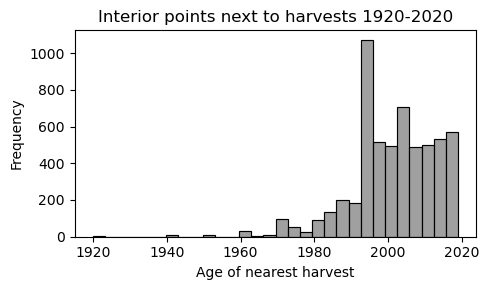

In [103]:

# Plot histogram
plt.figure(figsize=(5, 3))
sns.histplot(BU_points_within_500m['nearest_poly_year'], bins=30, kde=False, color = "gray")
plt.xlabel('Age of nearest harvest')
plt.ylabel('Frequency')
plt.grid(False)
plt.title("Interior points next to harvests 1920-2020")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "Points all ages no filtering"))

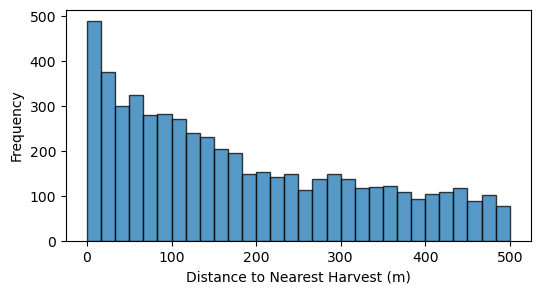

In [95]:
plt.figure(figsize=(6, 3))
plt.hist(BU_points_within_500m_post_1980['distance_to_nearest_harv'], bins=30, alpha=0.75, edgecolor='black')
plt.xlabel('Distance to Nearest Harvest (m)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [96]:
BU_points_within_500m_post_1980.to_file(os.path.join(processed_path, "shapefiles", "BU_locations_within500m_post_1980_harvest_3400.shp"))

C:\Users\ilebe\AppData\Local\Temp\ipykernel_30048\3443820703.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  BU_points_within_500m_post_1980.to_file(os.path.join(processed_path, "shapefiles", "BU_locations_within500m_post_1980_harvest_3400.shp"))


In [104]:
BU_points_within_500m_post_1980.drop(labels='distance_to_poly', axis = 1, inplace=True)

C:\Users\ilebe\AppData\Local\Temp\ipykernel_30048\657049649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BU_points_within_500m_post_1980.drop(labels='distance_to_poly', axis = 1, inplace=True)


# D. Get the locations that are recordings.
Scour the BUPublic server.

In [8]:
import datetime as dt

In [2]:

def find_files(start_path, extensions, skip_folders):
    # List to store file info dictionaries
    files_info = []

    # Convert skip_folders to a set for faster lookup
    skip_folders_set = set(skip_folders)

    # Walk through the directory structure
    for root, dirs, files in os.walk(start_path):
        # Extract the immediate directory name under start_path
        immediate_directory = os.path.relpath(root, start_path).split(os.sep)[0]

        # Skip the directories in skip_folders
        if immediate_directory in skip_folders_set:
            continue

        for file in files:
            # Check if the file has one of the desired extensions
            if file.endswith(tuple(extensions)):
                # Extract the last directory name
                last_directory_name = os.path.basename(root)
                # Construct the full path to the file
                full_path = os.path.join(root, file)
                # Add the file info to the list
                files_info.append({
                    'location': last_directory_name,
                    'recording': file,
                    'filepath': full_path
                })

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(files_info)
    return df

# Specify the starting directory, e.g., '/path/to/start/directory'
start_directory = r"X:\BU\ARU"
# Specify the file extensions you're interested in
extensions = ['.flac', '.wav', '.wac']
# Specify the folders to skip (relative to start_directory)
skip_folders = ["BAT", "BATPAIRED", "ELE", "CONI", "RETN", "Y", "WLNP"]

# Find the files and get the DataFrame
df_files = find_files(start_directory, extensions, skip_folders)

In [3]:
df_files.to_csv(os.path.join(processed_path, "BU_public_df.csv"))

In [6]:
df_files.head()
BU_public = df_files.copy(deep=True)

In [7]:
BU_public.head()

,location,recording,filepath
0,AIEES-5BN-152,AIEES-5BN-152_20140525_125827.wav,X:\BU\ARU\AIEES\2014\AIEES-5BN\AIEES-5BN-152\A...
1,AIEES-5BN-152,AIEES-5BN-152_20140525_140000.wav,X:\BU\ARU\AIEES\2014\AIEES-5BN\AIEES-5BN-152\A...
2,AIEES-5BN-152,AIEES-5BN-152_20140525_150000.wav,X:\BU\ARU\AIEES\2014\AIEES-5BN\AIEES-5BN-152\A...
3,AIEES-5BN-152,AIEES-5BN-152_20140525_160000.wav,X:\BU\ARU\AIEES\2014\AIEES-5BN\AIEES-5BN-152\A...
4,AIEES-5BN-152,AIEES-5BN-152_20140525_170000.wav,X:\BU\ARU\AIEES\2014\AIEES-5BN\AIEES-5BN-152\A...


### Omit the locations not in the shapefile

In [12]:
BU_points =  gpd.read_file(os.path.join(processed_path, "shapefiles", "BU_locations_within500m_post_1980_harvest_3400.shp"))

In [14]:
BU_points_list = BU_points.location.to_list()

In [15]:
BU_public_correct_points = BU_public[BU_public['location'].isin(BU_points_list)]

In [17]:
print(BU_public_correct_points.shape)
print(BU_public.shape)

(1391183, 5)
(5275714, 5)


In [18]:
BU_public_correct_points.to_csv(os.path.join(processed_path, "BU_public_correct_points_df.csv"))

In [25]:
BU_public_correct_points = pd.read_csv(os.path.join(processed_path, "BU_public_correct_points_df.csv"))

In [22]:
bad = str("H-P15-5-8_20210624T180000-0600_REC [+51.4947-115.1875]")
bad.split("-0600_REC")[0]

'H-P15-5-8_20210624T180000'

In [27]:
def extract_datetime(x):
    try:
        # Your original processing and datetime extraction
        formatted_x = str(x).split("-0600_REC")[0].split("+0000")[0][-15:].replace('T', "_").replace('$', "_")
        return dt.datetime.strptime(formatted_x, "%Y%m%d_%H%M%S")
    except ValueError as e:
        # Print out the problematic value and the error
        print(f"Error processing row with value '{x}': {e}")
        return None  # Or return pd.NaT if you prefer to use pandas' NaT for missing timestamp data

# Apply the function to the 'Temp_column' to extract datetime
BU_public_correct_points['RecordingDate'] = BU_public_correct_points['Temp_column'].apply(extract_datetime)

Error processing row with value 'R-E0-19-61_20210601_050000 (2)': time data '0601_050000 (2)' does not match format '%Y%m%d_%H%M%S'
Error processing row with value 'R-E0-7-51_REC [+52.7931-115.0986]': time data '.7931-115.0986]' does not match format '%Y%m%d_%H%M%S'


In [32]:
BU_public_correct_points.loc[BU_public_correct_points['Temp_column'] == 'R-E0-19-61_20210601_050000 (2)']

,Unnamed: 0,location,recording,filepath,Temp_column,RecordingDate
563137,2040881,R-E0-19-61,R-E0-19-61_20210601_050000 (2).wac,X:\BU\ARU\EDGEROAD\2021\V1\R-19B\R-E0-19-61\R-...,R-E0-19-61_20210601_050000 (2),2021-06-01 05:00:00


In [31]:
BU_public_correct_points.loc[BU_public_correct_points['Temp_column'] == 'R-E0-19-61_20210601_050000 (2)', 'RecordingDate'] = dt.datetime(2021, 6, 1, 5, 0, 0)

In [35]:
BU_public_correct_points['RecordingDate'].isna().sum()
BU_public_correct_points.dropna(subset = 'RecordingDate', inplace=True)
print(BU_public_correct_points['RecordingDate'].isna().sum())

0


### D.2 Recording at dawn during Breeding Season

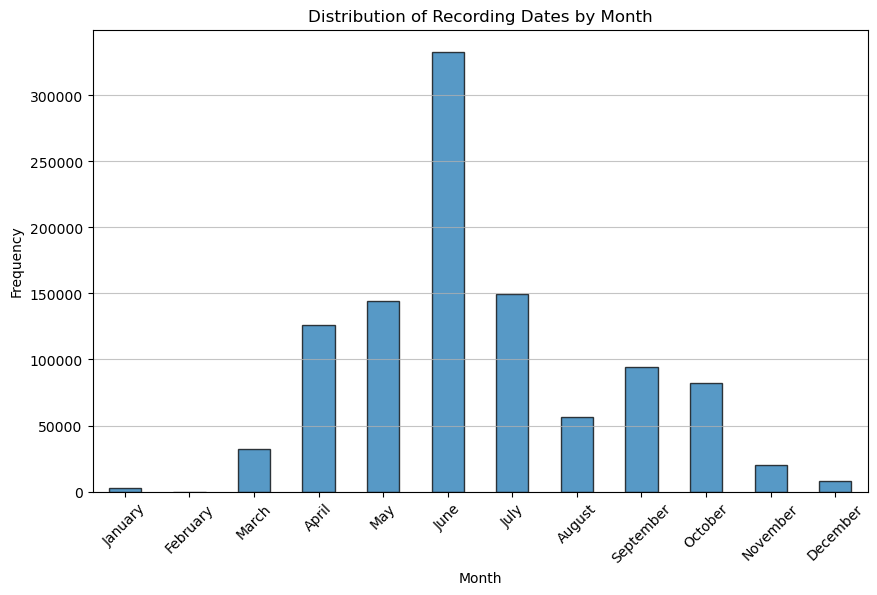

In [37]:
import calendar


# Extract the month from each date in the RecordingDate column and convert to month names
month_names = BU_public_correct_points['RecordingDate'].dt.month.apply(lambda x: calendar.month_name[x] if not pd.isna(x) else None)

# Count the frequency of each month name
month_counts = month_names.value_counts()

# Sort the month_counts by month order
month_order = [calendar.month_name[i] for i in range(1, 13)]
month_counts = month_counts.reindex(month_order)

# Plot a bar chart of the month frequencies
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
month_counts.plot(kind='bar', alpha=0.75, edgecolor='black')
plt.title('Distribution of Recording Dates by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the month names for better readability
plt.grid(axis='y', alpha=0.75)  # Enable horizontal grid lines for better readability
plt.show()

In [38]:
# Function to check if a date falls between May 26 and July 6
def is_date_within_range(date):
    if pd.isna(date):
        return False
    # Extract month and day
    month_day = (date.month, date.day)
    # Define the start (May 26) and end (July 6) of the range as month-day tuples
    range_start = (5, 26)
    range_end = (7, 6)
    # Check if the date falls within the range
    return range_start <= month_day <= range_end

# Apply the function to the RecordingDate column to filter the DataFrame
BU_public_spring_points = BU_public_correct_points[BU_public_correct_points['RecordingDate'].apply(is_date_within_range)]


In [40]:
BU_public_spring_points.drop(labels=['Unnamed: 0', 'Temp_column'], axis = 1, inplace=True)

C:\Users\ilebe\AppData\Local\Temp\ipykernel_1584\2561007590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BU_public_spring_points.drop(labels=['Unnamed: 0', 'Temp_column'], axis = 1, inplace=True)


In [46]:
len(BU_public_spring_points.location.unique())

1789

In [47]:
# Function to check if a datetime's time is between 04:00 and 09:00
def is_time_within_range(datetime):
    if pd.isna(datetime):
        return False
    # Extract time
    time = datetime.time()
    # Define start and end times
    start_time = dt.time(4, 0)
    end_time = dt.time(9, 0)
    # Check if the time falls within the range
    return start_time <= time <= end_time

# Apply the function to filter the DataFrame further
BU_public_spring_dawn_points = BU_public_spring_points[BU_public_spring_points['RecordingDate'].apply(is_time_within_range)]

In [49]:
len(BU_public_spring_dawn_points.location.unique())
print(BU_public_spring_dawn_points.shape)

(130452, 4)


In [50]:
BU_public_spring_dawn_points.to_csv(os.path.join(processed_path, "BU_public_spring_dawn_points_near_harv.csv"))

# E. Habitat around each point

Now that we have sites that are within 500m of the nearest harvest, and where the harvests are 1980-2019, we can omit sites that are in anything other than white spruce (17), aspen (29), and pine jack (23), lodgepole(23). <br>
First, calculate the area within 150m and the proportion of each raset pixel type. Then we can filter out the sites where there are too many undesirble tree species.

In [53]:
with rasterio.open(lead_tree_rater_path) as src:
    # Print basic metadata about the raster
    print(f"Raster width: {src.width}")
    print(f"Raster height: {src.height}")
    print(f"Number of bands: {src.count}")
    print(f"Coordinate Reference System (CRS): {src.crs}")
    print(f"Raster transform: {src.transform}")
    print(f"Pixel size: {src.res}")

Raster width: 193936
Raster height: 128340
Number of bands: 1
Coordinate Reference System (CRS): PROJCS["Lambert_Conformal_Conic_2SP",GEOGCS["NAD83",DATUM["North American Datum 1983",SPHEROID["GRS 1980",6378137,298.257222101004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-95],PARAMETER["standard_parallel_1",49],PARAMETER["standard_parallel_2",77],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Raster transform: | 30.00, 0.00,-2660910.52|
| 0.00,-30.00, 2998848.11|
| 0.00, 0.00, 1.00|
Pixel size: (30.0, 30.0)


Filter out the sites for which we don't have recordings in the correct time frame.

In [56]:
BU_points_within_500m_post_1980 = gpd.read_file(os.path.join(processed_path, "shapefiles", "BU_locations_within500m_post_1980_harvest_3400.shp"))

In [58]:
these_are_good_sites = list(BU_public_spring_dawn_points.location.unique())

In [60]:
BU_points_within_500m_post_1980_good_sites = BU_points_within_500m_post_1980[BU_points_within_500m_post_1980['location'].isin(these_are_good_sites)]
BU_points_within_500m_post_1980_good_sites.shape

(1751, 11)

<AxesSubplot:>

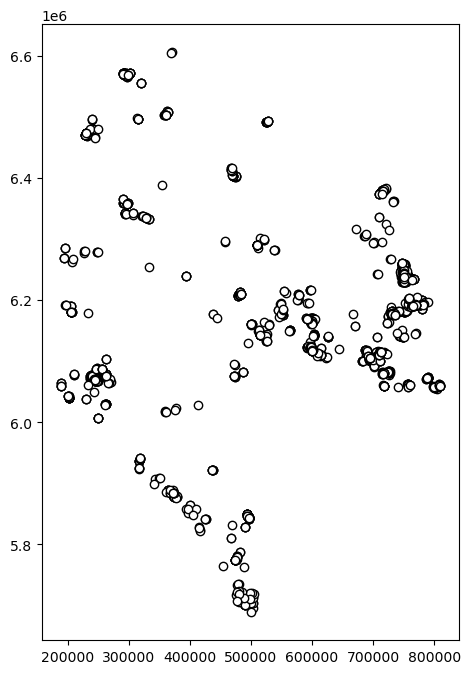

In [62]:

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

BU_points_within_500m_post_1980_good_sites.plot(ax=ax, facecolor = 'white', edgecolor = 'black')

In [68]:
BU_points_within_500m_post_1980_good_sites = BU_points_within_500m_post_1980_good_sites.drop(labels="geometry_150m", axis=1)

In [69]:
BU_points_within_500m_post_1980_good_sites.to_file(os.path.join(processed_path, 'shapefiles', 'BU_points_within_500m_post_1980_good_sites.shp'))

## E.2 Select points where the only harvest within 500 m is the nearest harvest.

In the BU_points gdf, nearest_po refers to the index of the harvest polygon in the Harvest gdf

In [4]:
BU_points = gpd.read_file(os.path.join(processed_path, 'shapefiles', 'BU_points_within_500m_post_1980_good_sites.shp'))

This code gives us the distance and the age of all the harvests within a 500m radius of each point.
That's within 0.7854 ${km^2}$

In [85]:

# Assuming BU_points_out_harvest_boreal_foothills_trim is your points GeoDataFrame
# Initialize columns to hold distances and years for ALL nearby polygons (within 500m)
BU_points['harvest_poly_details'] = np.nan

# Spatial index for the polygons GeoDataFrame
poly_sindex = Harvest_AREAS_polygons_gdf.sindex

for index, point in BU_points.iterrows():
    # Buffer the point by 500 meters to consider only nearby polygons
    buffered_point = point.geometry.buffer(500)
    
    # Use spatial index to find polygons within 500m buffer
    possible_matches_index = list(poly_sindex.intersection(buffered_point.bounds))
    possible_matches = Harvest_AREAS_polygons_gdf.iloc[possible_matches_index]
    
    # Skip if no matches
    if possible_matches.empty:
        continue
    
    # Calculate distance from point to each candidate polygon's edge
    point_to_poly_distances = possible_matches.distance(point.geometry)
    
    # Filter out polygons more than 500 meters away
    nearby_polygons = point_to_poly_distances[point_to_poly_distances <= 500]
    
    # Store details of each nearby polygon
    poly_details = [{'poly_id': pid, 'distance': dist, 'year': Harvest_AREAS_polygons_gdf.at[pid, 'YEAR']} 
                    for pid, dist in nearby_polygons.iteritems()]
    
    # Update the points GeoDataFrame with details of all nearby harvest polygons
    if poly_details:  # Check if the list is not empty
        BU_points.at[index, 'harvest_poly_details'] = str(poly_details)

C:\Users\ilebe\AppData\Local\Temp\ipykernel_1604\3560070421.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for pid, dist in nearby_polygons.iteritems()]


In [92]:
dict_BAM96 = BU_points[BU_points['location'] == "BAM-96"]["harvest_poly_details"][0]
dict_BAM96

"[{'poly_id': 125267, 'distance': 232.70497446046176, 'year': 2010}, {'poly_id': 125137, 'distance': 245.15823643277795, 'year': 2001}]"

In [98]:
BU_points.set_geometry(col = 'geometry', inplace=True)


In [107]:
# BU_points.rename(columns={'nearest__1': 'YEAR', "distance_t": "distance_nearest_harv"}, inplace=True)
# BU_points.rename(columns={"distance_t": "distance_nearest_harv"}, inplace=True)
BU_points.rename(columns={"nearest_po": "nearest_harv_index", "YEAR": "YEAR_nearest_harv"}, inplace=True)

In [109]:
BU_points.head(3)

,location,latitude,longitude,NSRNAME,NSRCODE,NRNAME,nearest_harv_index,distance_nearest_harv,distance_1,YEAR_nearest_harv,geometry,buffer,harvest_poly_details
0,BAM-96,57.127584,-117.766145,Dry Mixedwood,DMW,Boreal,125267.0,232.704974,232.704974,2010.0,POINT (332631.731 6332448.753),"POLYGON ((337296.708 6332653.366, 337296.769 6...","[{'poly_id': 125267, 'distance': 232.704974460..."
1,BAM-97,57.129393,-117.782274,Dry Mixedwood,DMW,Boreal,125137.0,214.962532,214.962532,2001.0,POINT (331664.357 6332689.653),"POLYGON ((336329.334 6332894.266, 336329.395 6...","[{'poly_id': 125137, 'distance': 214.962531838..."
2,BG-1-6,56.248017,-111.022350,Central Mixedwood,CM,Boreal,216513.0,66.243893,66.243893,1995.0,POINT (746311.911 6238302.718),"POLYGON ((750976.888 6238507.330, 750976.949 6...","[{'poly_id': 216513, 'distance': 66.2438932476..."


In [110]:
BU_points[['location', 'latitude', 'longitude', 'NSRNAME', 'NSRCODE', 'NRNAME',
       'nearest_harv_index', 'distance_nearest_harv', 'YEAR_nearest_harv', 'geometry', 'harvest_poly_details']].to_file(os.path.join(processed_path, "shapefiles", "BU_points_all_harv_within_500m_4300.shp"))

C:\Users\ilebe\AppData\Local\Temp\ipykernel_1604\187623932.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  BU_points[['location', 'latitude', 'longitude', 'NSRNAME', 'NSRCODE', 'NRNAME',


In [13]:
Harvest_AREAS_polygons_gdf.loc[Harvest_AREAS_polygons_gdf.index == 125267]

,OBJECTID,SOURCE,HFI_ID,FEATURE_TY,YEAR,SECTOR_HFI,Modifier_Y,Shape_Leng,Shape_Area,AnlysID,...,confHrvYr,confLnDstb,confNBRchg,confRegn,confY2R80,conf5yReg,confTotSum,regnMetsYN,regnAnlyYN,geometry
125267,125368,ABMI,{46CA0B1C-B314-486B-BA01-4CA0CD4ED0BE},HARVEST-AREA,2010,FORESTRY,0,965.781507,52350.698277,125368,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,N,Y,"POLYGON ((332770.563 6332653.188, 332764.988 6..."


## E.2 Dealing with confounding harvests nearby

Many sites have several harvests within 500m. However, if we delete all the sites that have more than 1 harvest within 500m, we will end up with nothing. There are 3 things to consider:
1. How close are the other harvests? I don't want to include confounding edge effects from other harvests. If I expect that edge effects will occur within a certian ditsance if the harvest is of a certain age, then I should omit sites where those edge effects could be at play.
    - All of the harvests here are younger than 1980.
2. I don't need to worry about the harvests that were logged AFTER the survey date. I have the survey date from the BU_public_spring_dawn_points_near_harv.csv file.
3. 

In [111]:
BU_public_spring_dawn_points = pd.read_csv(os.path.join(processed_path, "BU_public_spring_dawn_points_near_harv.csv"))

In [126]:
BU_public_spring_dawn_points['RecordingDate'] = pd.to_datetime(BU_public_spring_dawn_points['RecordingDate'])
BU_public_spring_dawn_points.dtypes
BU_public_spring_dawn_points.drop(labels = ['Unnamed: 0', 'RecordingDate '], inplace=True, axis=1)

In [129]:
BU_public_spring_dawn_points.head(1)

,location,recording,filepath,RecordingDate,SurveyYear
0,AM-420-CT,AM-420-CT_20140526_060000.wac,X:\BU\ARU\AM\2014\V1\AM-420\AM-420-CT\AM-420-C...,2014-05-26 06:00:00,2014


In [128]:
BU_public_spring_dawn_points['SurveyYear'] = BU_public_spring_dawn_points['RecordingDate'].dt.year

In [132]:
BU_public_spring_dawn_points[['location', 'SurveyYear']].to_csv(os.path.join(processed_path, "BU_public_good_points_survey_year.csv"), index = False)

In [130]:
location_survey_year = dict(zip(BU_public_spring_dawn_points['location'], BU_public_spring_dawn_points['SurveyYear']))
location_survey_year

{'AM-420-CT': 2015,
 'AM-420-NE': 2015,
 'AM-420-NW': 2015,
 'AM-420-SE': 2015,
 'AM-422-CT': 2014,
 'AM-422-NE': 2014,
 'AM-422-NW': 2014,
 'AM-422-SW': 2014,
 'AM-424-CT': 2022,
 'AM-424-NE': 2022,
 'AM-426-CT': 2017,
 'AM-426-NE': 2017,
 'AM-426-SE': 2016,
 'AM-426-SW': 2016,
 'AM-427-CT': 2015,
 'AM-427-NE': 2015,
 'AM-427-NW': 2015,
 'AM-427-SE': 2015,
 'AM-427-SW': 2015,
 'AM-432-SW': 2014,
 'AM-433-SE': 2017,
 'AM-435-NW': 2014,
 'AM-435-SW': 2014,
 'AM-439-SW': 2022,
 'AM-441-CT': 2017,
 'AM-441-NW': 2017,
 'AM-441-SW': 2017,
 'AM-414-SW': 2019,
 'AM-420-SW': 2015,
 'AM-442-CT': 2021,
 'AM-442-NE': 2018,
 'AM-442-SE': 2018,
 'AM-442-SW': 2021,
 'AM-423-CT': 2017,
 'AM-423-NE': 2017,
 'AM-423-NW': 2017,
 'AM-423-SE': 2017,
 'AM-423-SW': 2017,
 'ARTI-1-NE': 2018,
 'ARTI-1-SE': 2018,
 'ARTI-4-NW': 2018,
 'ARTI-9-NE': 2018,
 'ARTI-9-NW': 2018,
 'ARTI-9-SE': 2018,
 'ARTI-9-SW': 2018,
 'BAM-2-5': 2019,
 'BAM-4-28': 2019,
 'BAM-4-29': 2019,
 'BAM-6-32': 2019,
 'BAM-6-33': 2019,
 'BAM-

In [161]:
import ast
BU_points['Harvest_dict'] = BU_points['harvest_poly_details'].apply(lambda x: ast.literal_eval(x)[0] if x else None)
BU_points.head(1)

,location,latitude,longitude,NSRNAME,NSRCODE,NRNAME,nearest_harv_index,distance_nearest_harv,distance_1,YEAR_nearest_harv,geometry,buffer,harvest_poly_details,Harvest_dict
0,BAM-96,57.127584,-117.766145,Dry Mixedwood,DMW,Boreal,125267.0,232.704974,232.704974,2010.0,POINT (332631.731 6332448.753),"POLYGON ((337296.708 6332653.366, 337296.769 6...","[{'poly_id': 125267, 'distance': 232.704974460...","{'poly_id': 125267, 'distance': 232.7049744604..."


In [232]:
BU_points_harv_year = BU_points.merge(right = BU_public_spring_dawn_points[['location', 'SurveyYear']], how = "left", on= 'location')

In [170]:
BU_points.columns

Index(['location', 'latitude', 'longitude', 'NSRNAME', 'NSRCODE', 'NRNAME',
       'nearest_harv_index', 'distance_nearest_harv', 'distance_1',
       'YEAR_nearest_harv', 'geometry', 'buffer', 'harvest_poly_details',
       'Harvest_dict'],
      dtype='object')

In [236]:
BU_points_harv_year_no_dups = BU_points_harv_year[['location', 'latitude', 'longitude', 'NSRNAME', 'NSRCODE', 'NRNAME',
       'nearest_harv_index', 'distance_nearest_harv', 'distance_1',
       'YEAR_nearest_harv', 'geometry', 'buffer', 'harvest_poly_details', 'SurveyYear']].drop_duplicates()

In [204]:
# BU_points_harv_year_no_dups = BU_points_harv_year_no_dups.merge(right = BU_public_spring_dawn_points[['location', 'SurveyYear']], how = "left", on= 'location')

In [239]:
BU_points_harv_year_no_dups['Harvest_dict'] = BU_points_harv_year_no_dups['harvest_poly_details'].apply(lambda x: ast.literal_eval(x) if x else None)

In [237]:
BU_points_harv_year_no_dups.head(2)

,location,latitude,longitude,NSRNAME,NSRCODE,NRNAME,nearest_harv_index,distance_nearest_harv,distance_1,YEAR_nearest_harv,geometry,buffer,harvest_poly_details,SurveyYear
0,BAM-96,57.127584,-117.766145,Dry Mixedwood,DMW,Boreal,125267.0,232.704974,232.704974,2010.0,POINT (332631.731 6332448.753),"POLYGON ((337296.708 6332653.366, 337296.769 6...","[{'poly_id': 125267, 'distance': 232.704974460...",2020
10,BAM-97,57.129393,-117.782274,Dry Mixedwood,DMW,Boreal,125137.0,214.962532,214.962532,2001.0,POINT (331664.357 6332689.653),"POLYGON ((336329.334 6332894.266, 336329.395 6...","[{'poly_id': 125137, 'distance': 214.962531838...",2020


In [238]:
# print(BU_points_harv_year.shape)
print(BU_points_harv_year_no_dups.shape)

(2023, 14)


In [178]:
BU_points_harv_year = None

In [193]:
BU_points_harv_year_no_dups["Harvest_dict"][0]

{'poly_id': 125267, 'distance': 232.70497446046176, 'year': 2010}

In [240]:
def filter_harvest_dicts(row):
    # Extract the list of dictionaries from the Harvest_dict column
    harvest_dicts_list = row['Harvest_dict']
    
    # # Filter the list to keep only those dictionaries where 'year' < SurveyYear
    # print(type(harvest_dicts['year']))
    # print(type(row["SurveyYear"]))
    # for d in harvest_dicts_list:
    #     print(d)
        # if d['year'] < 2020:
        #     print("yippee")
    filtered_harvests = [d for d in harvest_dicts_list if d['year'] < row['SurveyYear']]
    
    return filtered_harvests

# Apply the function to each row and assign the result to a new column
BU_points_harv_year_no_dups['Filtered_Harvest_dict'] = BU_points_harv_year_no_dups.apply(filter_harvest_dicts, axis=1)


In [227]:
this_list = [{1:2}, {2:2}]
len(this_list)

2

In [241]:
BU_points_harv_year_no_dups.shape

(2023, 16)

In [243]:
BU_points_harv_year_no_dups['Number_all_harv'] = BU_points_harv_year_no_dups['Harvest_dict'].apply(lambda row: len(row))
BU_points_harv_year_no_dups['Number_older_harv'] = BU_points_harv_year_no_dups['Filtered_Harvest_dict'].apply(lambda row: len(row))
BU_points_harv_year_no_dups.head(2)

,location,latitude,longitude,NSRNAME,NSRCODE,NRNAME,nearest_harv_index,distance_nearest_harv,distance_1,YEAR_nearest_harv,geometry,buffer,harvest_poly_details,SurveyYear,Harvest_dict,Filtered_Harvest_dict,Number_all_harv,Number_older_harv
0,BAM-96,57.127584,-117.766145,Dry Mixedwood,DMW,Boreal,125267.0,232.704974,232.704974,2010.0,POINT (332631.731 6332448.753),"POLYGON ((337296.708 6332653.366, 337296.769 6...","[{'poly_id': 125267, 'distance': 232.704974460...",2020,"[{'poly_id': 125267, 'distance': 232.704974460...","[{'poly_id': 125267, 'distance': 232.704974460...",2,2
10,BAM-97,57.129393,-117.782274,Dry Mixedwood,DMW,Boreal,125137.0,214.962532,214.962532,2001.0,POINT (331664.357 6332689.653),"POLYGON ((336329.334 6332894.266, 336329.395 6...","[{'poly_id': 125137, 'distance': 214.962531838...",2020,"[{'poly_id': 125137, 'distance': 214.962531838...","[{'poly_id': 125137, 'distance': 214.962531838...",1,1


In [244]:
BU_points_harv_year_no_dups['Number_older_harv'].value_counts()

1     527
2     447
3     318
4     220
5     148
6     108
0      65
7      58
8      46
9      27
10     23
11     20
13      5
12      4
15      3
14      2
17      1
16      1
Name: Number_older_harv, dtype: int64

There are 527 sites with only 1 harvest within 500m!

In [245]:
BU_points_harv_year_no_dups.columns

Index(['location', 'latitude', 'longitude', 'NSRNAME', 'NSRCODE', 'NRNAME',
       'nearest_harv_index', 'distance_nearest_harv', 'distance_1',
       'YEAR_nearest_harv', 'geometry', 'buffer', 'harvest_poly_details',
       'SurveyYear', 'Harvest_dict', 'Filtered_Harvest_dict',
       'Number_all_harv', 'Number_older_harv'],
      dtype='object')

In [248]:
BU_points_harv_year_no_dups[['location', 'latitude', 'longitude', 'NSRNAME', 'NSRCODE', 'NRNAME',
       'nearest_harv_index', 'distance_nearest_harv', 'distance_1',
       'YEAR_nearest_harv', 'geometry', 
       'SurveyYear', 
       'Number_all_harv', 'Number_older_harv']].to_file(os.path.join(processed_path, 'shapefiles', "BU_points_harv_yeardetails_no_dups_3400.shp"))

C:\Users\ilebe\AppData\Local\Temp\ipykernel_1604\2428953250.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  BU_points_harv_year_no_dups[['location', 'latitude', 'longitude', 'NSRNAME', 'NSRCODE', 'NRNAME',


In [ ]:
BU_points_contiguous_forest = BU_points_harv_year_no_dups.loc[BU_points_harv_year_no_dups['Number_older_harv'] == 1]

In [251]:
BU_points_contiguous_forest['Year_since_harvest'] = BU_points_contiguous_forest['SurveyYear'] - BU_points_contiguous_forest['YEAR_nearest_harv']

c:\Users\ilebe\anaconda3\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [7]:
Interior_points = pd.read_csv(os.path.join(processed_path, "Valid_BU_interior_points_ageOfHarv.csv"))

In [10]:
Interior_points.head(2)

,location,latitude,longitude,NSRNAME,NSRCODE,NRNAME,nearest_harv_index,distance_nearest_harv,YEAR_nearest_harv,SurveyYear,Number_older_harv,Year_since_harvest
0,BAM-97,57.129393,-117.782274,Dry Mixedwood,DMW,Boreal,125137.0,214.962532,2001.0,2020,1,19.0
1,BG-1-9,56.247926,-110.973615,Central Mixedwood,CM,Boreal,223059.0,428.196015,1994.0,2014,1,20.0


In [24]:
Interior_points['adjusted Year_since_harvest'] = Interior_points['Year_since_harvest']
Interior_points.loc[Interior_points['Year_since_harvest'] <0, 'adjusted Year_since_harvest'] = 1
Interior_points[Interior_points['adjusted Year_since_harvest'] < 0]


,location,latitude,longitude,NSRNAME,NSRCODE,NRNAME,nearest_harv_index,distance_nearest_harv,YEAR_nearest_harv,SurveyYear,Number_older_harv,Year_since_harvest,adjusted Year_since_harvest


In [61]:
Interior_points_250 = Interior_points[Interior_points['distance_nearest_harv'] < 250]

In [81]:
Interior_points_250.loc[Interior_points['NSRNAME'] == 20]

,location,latitude,longitude,NSRNAME,NSRCODE,NRNAME,nearest_harv_index,distance_nearest_harv,YEAR_nearest_harv,SurveyYear,Number_older_harv,Year_since_harvest,adjusted Year_since_harvest,Frequency


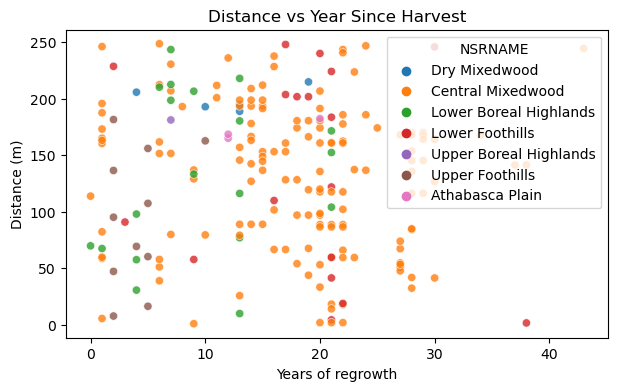

In [109]:
# Plotting
plt.figure(figsize=(7, 4))
sns.scatterplot(data=Interior_points_250, x='adjusted Year_since_harvest', y='distance_nearest_harv', hue = "NSRNAME", alpha=0.8)
# sns.move_legend(scatter, "upper left",title='Natural Subregions')
plt.title('Distance vs Year Since Harvest')
plt.xlabel('Years of regrowth')
plt.ylabel('Distance (m)')
# plt.show()
plt.savefig(os.path.join(output_path, "distance vs year since harvest.png"),bbox_inches="tight", dpi=300)


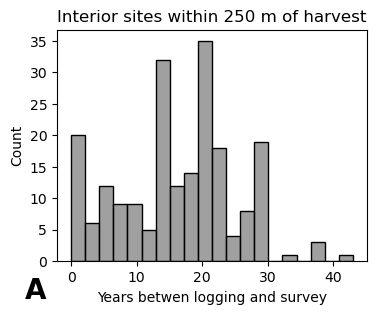

In [53]:
# Plotting
plt.figure(figsize=(4, 3))

# Histogram
# plt.subplot(2, 2, 1)
sns.histplot(Interior_points[Interior_points['distance_nearest_harv'] < 250]['adjusted Year_since_harvest'], bins=20, kde=False, color = "gray")
plt.xlabel('Years betwen logging and survey')  # Set x-axis label
plt.title('Interior sites within 250 m of harvest')
plt.text(-7, -7, 'A', fontsize=20, fontweight='bold', ha='left', va='bottom')
plt.savefig(os.path.join(output_path, "interior BU points and time since harvest within 250 m.png"), bbox_inches="tight", dpi=300)

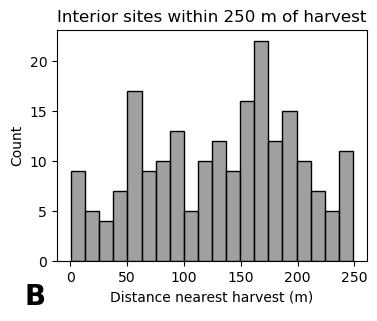

In [57]:
# Plotting
plt.figure(figsize=(4, 3))

# Histogram
# plt.subplot(2, 2, 1)
sns.histplot(Interior_points[Interior_points['distance_nearest_harv'] < 250]['distance_nearest_harv'], bins=20, kde=False, color = "gray")
plt.xlabel('Distance nearest harvest (m)')  # Set x-axis label
plt.title('Interior sites within 250 m of harvest')
plt.text(-40, -5, 'B', fontsize=20, fontweight='bold', ha='left', va='bottom')
plt.savefig(os.path.join(output_path, "interior BU points and distance nearest harvest within 250 m.png"), bbox_inches="tight", dpi=300)

In [110]:
Interior_points[Interior_points['distance_nearest_harv'] < 250].shape

(208, 13)

In [255]:
Valid_interior_sites_list = BU_points_contiguous_forest['location'].to_list()

In [260]:
BU_points_contiguous_forest.head(2)

,location,latitude,longitude,NSRNAME,NSRCODE,NRNAME,nearest_harv_index,distance_nearest_harv,distance_1,YEAR_nearest_harv,geometry,buffer,harvest_poly_details,SurveyYear,Harvest_dict,Filtered_Harvest_dict,Number_all_harv,Number_older_harv,Year_since_harvest
10,BAM-97,57.129393,-117.782274,Dry Mixedwood,DMW,Boreal,125137.0,214.962532,214.962532,2001.0,POINT (331664.357 6332689.653),"POLYGON ((336329.334 6332894.266, 336329.395 6...","[{'poly_id': 125137, 'distance': 214.962531838...",2020,"[{'poly_id': 125137, 'distance': 214.962531838...","[{'poly_id': 125137, 'distance': 214.962531838...",1,1,19.0
170,BG-1-9,56.247926,-110.973615,Central Mixedwood,CM,Boreal,223059.0,428.196015,428.196015,1994.0,POINT (749328.474 6238468.043),"POLYGON ((753993.451 6238672.656, 753993.512 6...","[{'poly_id': 223059, 'distance': 428.196015479...",2014,"[{'poly_id': 223059, 'distance': 428.196015479...","[{'poly_id': 223059, 'distance': 428.196015479...",1,1,20.0


In [261]:
BU_points_contiguous_forest[['location', 'latitude', 'longitude', 'NSRNAME', 'NSRCODE', 'NRNAME',
       'nearest_harv_index', 'distance_nearest_harv',
       'YEAR_nearest_harv',
       'SurveyYear',  'Number_older_harv', 'Year_since_harvest']].to_csv(os.path.join(processed_path, "Valid_BU_interior_points_ageOfHarv.csv"), index = False)

In [197]:
dict_BAM96 = BU_points[BU_points['location'] == "BAM-96"]["harvest_poly_details"][0][1:-1]
# type(dict_BAM96)
dict_BAM96

"{'poly_id': 125267, 'distance': 232.70497446046176, 'year': 2010}, {'poly_id': 125137, 'distance': 245.15823643277795, 'year': 2001}"

# F. Get the habitat type around each point

In [270]:
BU_points_harv_year = None
BU_public_spring_dawn_points = None

In [271]:
BU_points_contiguous_forest_ready = BU_points_contiguous_forest[['location', 'latitude', 'longitude', 'NSRNAME', 'NSRCODE', 'NRNAME',
       'nearest_harv_index', 'distance_nearest_harv',
       'YEAR_nearest_harv', 'geometry',
       'SurveyYear',  'Number_older_harv', 'Year_since_harvest']]

In [272]:
BU_points_contiguous_forest_ready.head(1)

,location,latitude,longitude,NSRNAME,NSRCODE,NRNAME,nearest_harv_index,distance_nearest_harv,YEAR_nearest_harv,geometry,SurveyYear,Number_older_harv,Year_since_harvest
10,BAM-97,57.129393,-117.782274,Dry Mixedwood,DMW,Boreal,125137.0,214.962532,2001.0,POINT (331664.357 6332689.653),2020,1,19.0


Intersect the raster with point buffers.
1. Clip the raset file to the alberta outline
2. Transform the rasters as polygons.
3. Interect the buffered points to the tree polygons

In [273]:
alberta = gpd.read_file(r"C:\Users\ilebe\Documents\!Masters!\Alberta-GIS-Ecology-Tools-1\alberta shapefile\alberta.shp")

In [276]:
alberta.crs

<Projected CRS: PROJCS["PCS_Lambert_Conformal_Conic",GEOGCS["GCS_N ...>
Name: PCS_Lambert_Conformal_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [277]:
alberta3400 = alberta.to_crs(epsg=3400)

<AxesSubplot:>

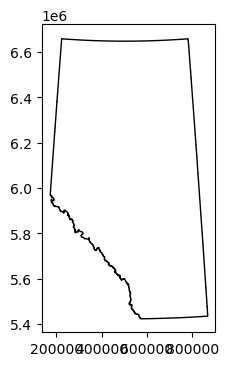

In [280]:
# Plot the data
fig, ax = plt.subplots(figsize=(6, 4))

alberta3400.plot(ax=ax, facecolor = 'white', edgecolor = 'black')

In [281]:
import rasterio
from rasterio.plot import show

# Replace 'your_raster_file.tif' with the path to your raster file
raster_file = lead_tree_raster_path
raster = rasterio.open(raster_file)


In [286]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Get the CRS of the shapefile
shapefile_crs = alberta3400.crs

# Open the original raster
with rasterio.open(lead_tree_raster_path) as src:
    # Calculate the transformation and new dimensions for the target CRS
    transform, width, height = calculate_default_transform(
        src.crs, shapefile_crs, src.width, src.height, *src.bounds)
    
    # Update the metadata for the reprojected raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': shapefile_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Reproject and save the raster to a new file
    with rasterio.open('LeadTree3400.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=shapefile_crs,
                resampling=Resampling.nearest)


In [287]:
LeadTree3400 = rasterio.open('LeadTree3400.tif')


In [288]:
LeadTree3400.crs

CRS.from_wkt('LOCAL_CS["NAD83 / Alberta 10-TM (Forest)",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [289]:
from rasterio.mask import mask

# Extract the geometry in GeoJSON format
geoms = alberta3400.geometry.values  # GeoDataFrame to numpy array
geometry = geoms[0]  # Assuming only one geometry (province border)
geojson = geometry.__geo_interface__

# Clip the raster with the polygon
out_image, out_transform = mask(LeadTree3400, [geojson], crop=True)

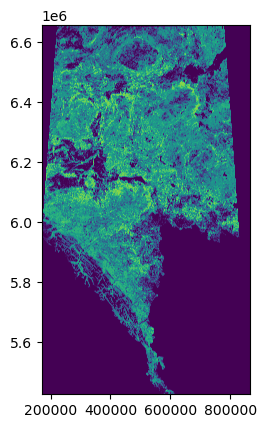

<AxesSubplot:>

In [291]:
# Optionally, visualize the clipped raster
show(out_image[0], transform=out_transform)

In [292]:
# Copy the metadata of the original raster
out_meta = raster.meta.copy()

# Update the metadata with new dimensions, transform, and CRS
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Write the clipped raster to a new file
with rasterio.open('AB_clipped_Lead_tree3400.tif', "w", **out_meta) as dest:
    dest.write(out_image)

In [294]:
# Step 1: Read the raster file
with rasterio.open('AB_clipped_Lead_tree3400.tif') as src:
    # Step 2: Convert the raster to a NumPy array
    raster_array = src.read(1)  # Assuming you're interested in the first band
    
    # Step 3: Generate polygons from the raster
    results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) in enumerate(
            shapes(raster_array, mask=None, transform=src.transform)))  # Use `masked_array.mask` instead of None if using a mask
    
    # Step 4: Convert the polygons into a GeoDataFrame
    geoms = list(results)
    LeadTree_polygons = gpd.GeoDataFrame.from_features(geoms)

In [ ]:
LeadTree_polygons

In [ ]:

# Set the intersected feature class
intersected_fc = "Interior_250_Intersect"

# Retrieve unique polygon IDs and tree species
polygon_ids = list(set([row[0] for row in arcpy.da.SearchCursor(intersected_fc, ['location'])]))
tree_species = list(set([row[0] for row in arcpy.da.SearchCursor(intersected_fc, ['gridcode'])]))

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['location', 'Tree_Species', 'Percentage'])

# Calculate the area of each tree species within individual polygons
for polygon_id in polygon_ids:
    total_area = 0
    tree_species_areas = {species: 0 for species in tree_species}

    with arcpy.da.SearchCursor(intersected_fc, ['location', 'gridcode', 'Shape_Area']) as cursor:
        for row in cursor:
            if row[0] == polygon_id:
                total_area += row[2]
                tree_species_areas[row[1]] += row[2]

    # Calculate the percentage and append to the results DataFrame
    for species, area in tree_species_areas.items():
        percentage = (area / total_area) * 100
        results_df = results_df.append({'Polygon_ID': polygon_id, 'Tree_Species': species, 'Percentage': percentage}, ignore_index=True)

# Print the final results
print(results_df)


In [63]:
# Step 1: Create a 150m buffer around each point
BU_points_within_500m_post_1980_good_sites['geometry_150m'] = BU_points_within_500m_post_1980_good_sites['geometry'].buffer(150)


# Define the area covered by each pixel
pixel_area = 30 * 30  # Each pixel is 30m x 30m

# The total area of a 150m radius circle
total_area = np.pi * (150 ** 2)

with rasterio.open(lead_tree_rater_path) as src:
    for ji, window in src.block_windows(1):
        data = src.read(1, window=window)
    affine = src.transform
    array = src.read(1) 
    # Calculate zonal statistics for each buffered point
    stats = zonal_stats(BU_points_within_500m_post_1980_good_sites, array, affine=affine, stats="count", categorical=True, nodata=src.nodata)

# Convert the stats to proportions of the total area
proportions_list = []
for stat in stats:
    if stat:  # Check if the dictionary is not empty
        proportions = {str(k): (v * pixel_area) / total_area for k, v in stat.items()}
    else:
        proportions = {}
    proportions_list.append(proportions)

# Convert the list of dictionaries to a DataFrame
proportions_df = pd.DataFrame(proportions_list)

# Fill NaN values with 0, since no coverage implies 0% proportion
proportions_df.fillna(0, inplace=True)

# Join the proportions back to the points GeoDataFrame
points_gdf = BU_points_within_500m_post_1980_good_sites.join(proportions_df)

c:\Users\ilebe\anaconda3\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\ilebe\anaconda3\lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
